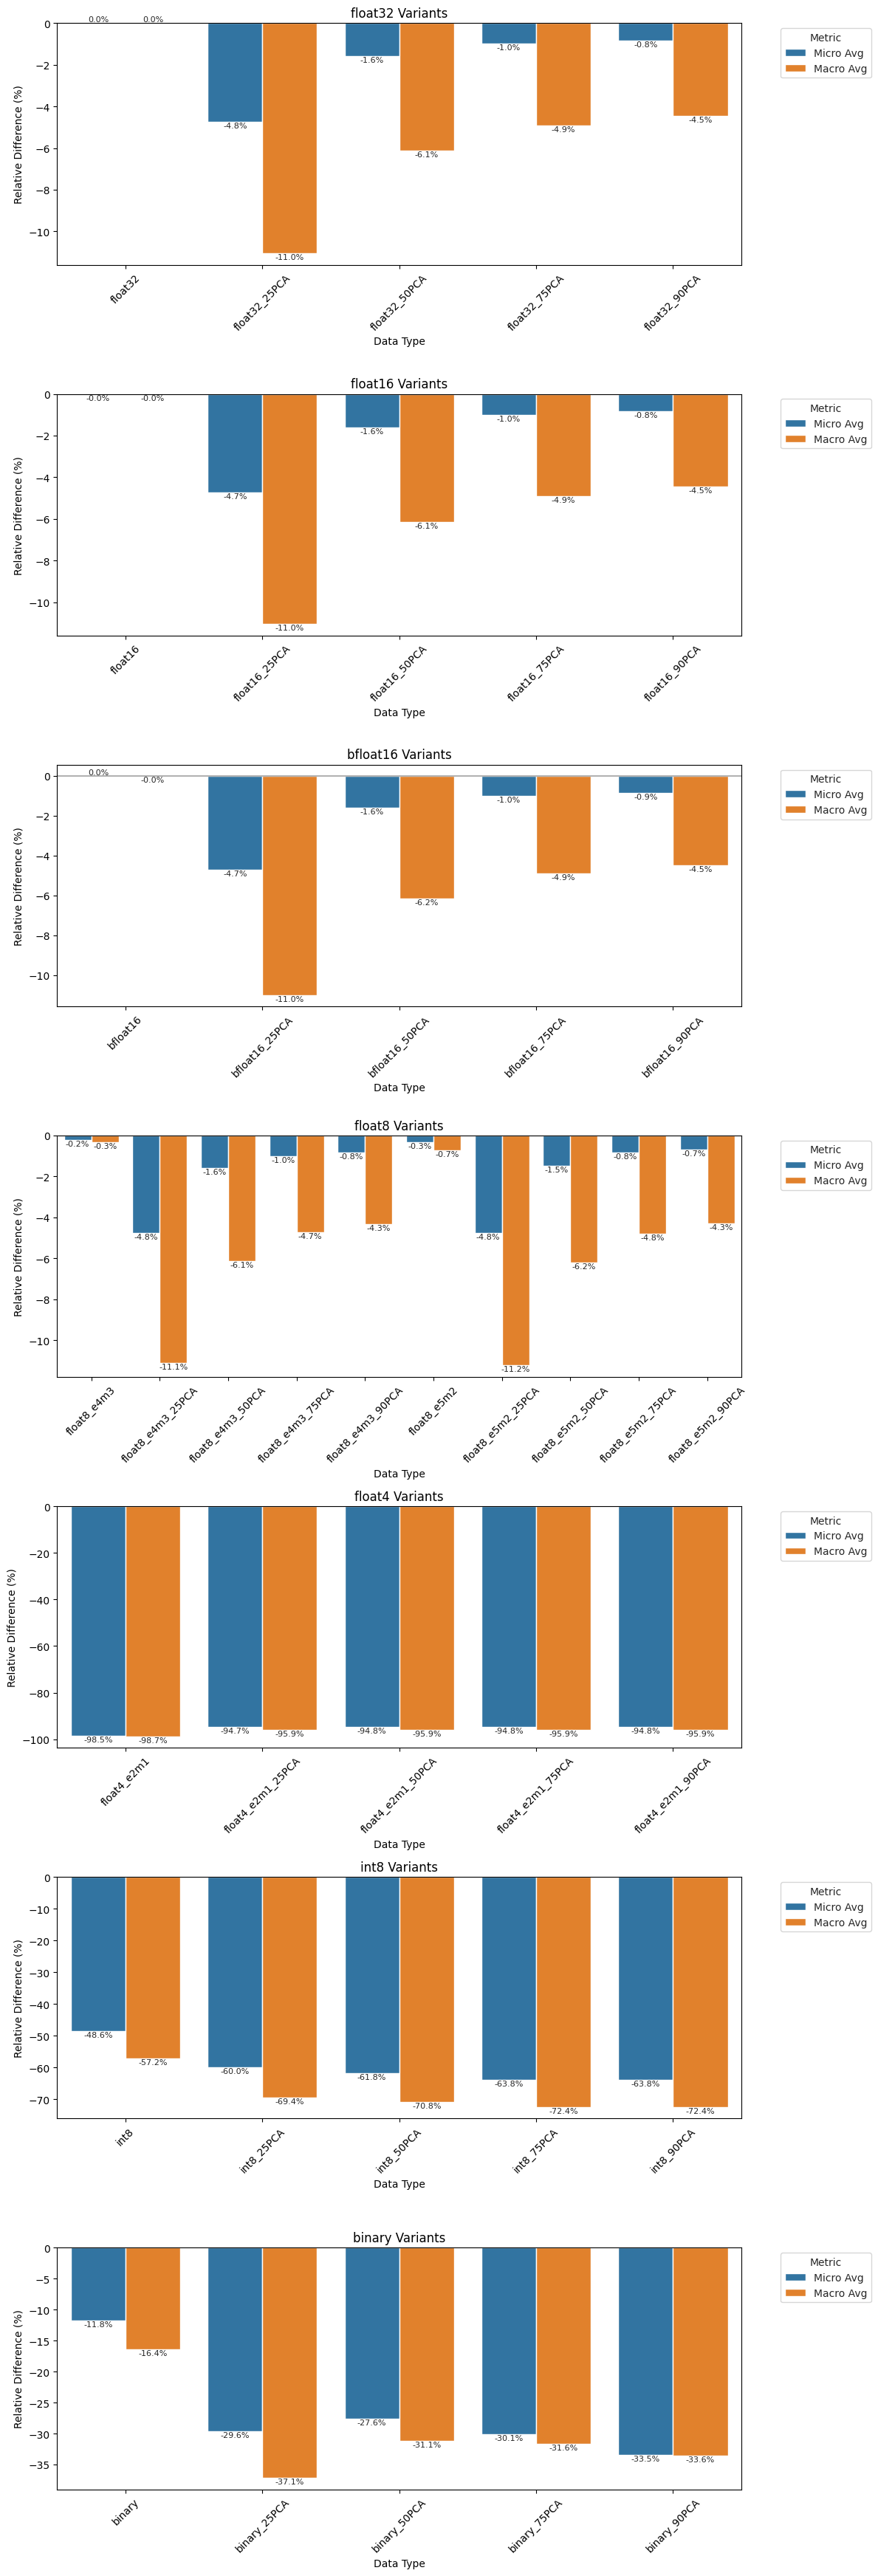

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Get all result files from the experiment directory
results_dir = Path('../results/BAAI/bge-small-en-v1.5')
result_files = list(results_dir.glob('results_*.json'))

# Load float32 baseline scores
with open(results_dir / 'results_float32.json', 'r') as f:
    float32_data = json.load(f)
    float32_scores = float32_data['scores']

# Group files by base data type
dtype_groups = {
    'float32': [],
    'float16': [],
    'bfloat16': [],
    'float8': [],
    'float4': [],
    'int8': [],
    'binary': []
}

for result_file in result_files:
    dtype = result_file.stem.replace('results_', '')
    # Check exact match for float16 and bfloat16 to avoid mixing them up
    if dtype == 'float16' or dtype.startswith('float16_'):
        dtype_groups['float16'].append(result_file)
    elif dtype == 'bfloat16' or dtype.startswith('bfloat16_'):
        dtype_groups['bfloat16'].append(result_file)
    else:
        # For other types, check if base type is in the name
        for base_type in ['float32', 'float8', 'float4', 'int8', 'binary']:
            if base_type in dtype:
                dtype_groups[base_type].append(result_file)

# Create subplot for each data type
fig, axes = plt.subplots(len(dtype_groups), 1, figsize=(12, 5*len(dtype_groups)))
# fig.suptitle('Relative Performance Difference vs float32 (no PCA)', fontsize=16)

for idx, (base_type, files) in enumerate(dtype_groups.items()):
    if not files:
        continue
        
    dtypes = []
    metrics = []
    relative_scores = []
    
    for result_file in files:
        dtype = result_file.stem.replace('results_', '')
        with open(result_file, 'r') as f:
            data = json.load(f)
            
        # Calculate micro average
        micro_avg = sum(data['scores'].values()) / len(data['scores'])
        micro_baseline = sum(float32_scores.values()) / len(float32_scores)
        micro_diff = ((micro_avg - micro_baseline) / micro_baseline) * 100
        
        # Calculate macro average
        macro_avg = sum(((score - float32_scores[benchmark]) / float32_scores[benchmark]) * 100 
                       for benchmark, score in data['scores'].items()) / len(data['scores'])
        
        dtypes.extend([dtype] * 2)
        metrics.extend(['Micro Avg', 'Macro Avg'])
        relative_scores.extend([micro_diff, macro_avg])

    df = pd.DataFrame({
        'dtype': dtypes,
        'metric': metrics,
        'relative_diff': relative_scores
    })

    # Create subplot
    sns.set_style("whitegrid")
    ax = axes[idx]
    sns.barplot(data=df, x='dtype', y='relative_diff', hue='metric', order=sorted(df['dtype'].unique()), ax=ax)
    
    ax.set_title(f'{base_type} Variants')
    ax.set_xlabel('Data Type')
    ax.set_ylabel('Relative Difference (%)')
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Add legend
    ax.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', fontsize=8)

plt.tight_layout()
plt.show()
